In [25]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#1. 【打开csv数据】
with open('Data_O2_Oxidation_3.csv', encoding = 'UTF-8') as f:
    df = pd.read_csv(f)  #index_col=0 告诉第一列是索引
    
#2. 【将非催化的和催化的数据分开来】
df_NonC = df[df['AcCom'] == 'Missing']
df_C = df[df['AcCom'] != 'Missing']

#3. 【下面导入不同催化剂的特性】
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.conversions import CompositionToOxidComposition
from matminer.featurizers.composition import OxidationStates

df_C = StrToComposition().featurize_dataframe(df_C, 'AcCom', ignore_errors=True) # 使用featurize_dataframe方法，并设置ignore_errors=True
#添加描述符
ep_feat = ElementProperty.from_preset(preset_name = 'magpie')   #添加一个名字叫‘magpie'的描述符集合
df_C = ep_feat.featurize_dataframe(df_C, col_id = 'composition')
df_C = CompositionToOxidComposition().featurize_dataframe(df_C, 'composition')
#组分氧化态的转化
os_feat = OxidationStates()
df_C = os_feat.featurize_dataframe(df_C, 'composition_oxid')

#4. 【重新合并】

columns_df_C = df_C.columns  # 获取df_C中所有的列
missing_columns = set(columns_df_C) - set(df_NonC.columns)  # 找出df_NonC中缺失的列
for column in missing_columns:  # 为df_NonC添加缺失的列，并初始化为NaN或其他适当的值
    df_NonC[column] = np.nan

df_NonC = df_NonC[columns_df_C]  # 确保列的顺序一致
df = pd.concat([df_C, df_NonC], ignore_index=True)  # 合并数据

#5. 【非数值列消除及缺失值的插值】
df.drop(['AcCom', 'composition', 'composition_oxid', 'OxiStat'], axis=1, inplace=True) #这里已经知道了这些列是非数值型列

df['BETs'] = pd.to_numeric(df['BETs'], errors='coerce') # 转换BETs列中的数值为float，忽略无法转换的错误
mean_value = df['BETs'].mean() # 计算除了NaN之外的均值
df['BETs'].fillna(mean_value, inplace=True) # 替换NaN为均值

df = df.apply(pd.to_numeric, errors='coerce') # 对所有列执行转换：将非数值的内容转为NaN，以便统一处理
column_means = df.mean() # 计算所有列的均值
df.fillna(column_means, inplace=True) # 替换所有NaN值为所在列的均值

#6. 【描述符筛选】
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

features = df.drop('Yld', axis=1)  # 去除目标变量列
target = df['Yld']

# 计算每个特征与目标变量之间的Pearson相关系数
correlations = {}
for column in features.columns:
    correlation, _ = pearsonr(features[column], target)
    correlations[column] = correlation
    
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation']) # 将相关系数转换为DataFrame
selected_features = corr_df[corr_df['Correlation'].abs() > 0.2] # 设定阈值，这里以0.2为例，保留与目标值相关性绝对值大于0.2的特征

# 从先前的步骤获取selected_features
selected_columns = selected_features.index.tolist()
selected_columns.append('Yld')  # 添加目标变量

# 创建新的DataFrame
new_df = df[selected_columns]

#下面计算选定特征互相之间的相关性
selected_df = df[selected_features.index]  # 创建一个只包含选定特征的DataFrame
correlation_matrix = selected_df.corr() # 计算相关性矩阵

# 寻找相关性大于0.9的特征对
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

#手动删除相关性大于0.9的特征对其一的描述符
excluded = ['S_c','MagpieData maximum Row','MagpieData maximum GSvolume_pa','MagpieData maximum GSbandgap', 'MagpieData range GSbandgap', 'MagpieData mean GSbandgap', 'MagpieData maximum NValence', 'MagpieData maximum MeltingT', 'MagpieData minimum Column', 'MagpieData minimum MendeleevNumber', 'MagpieData avg_dev NdValence','MagpieData maximum AtomicWeight', 'MagpieData range NValence','MagpieData avg_dev NValence','MagpieData mean GSvolume_pa']
df_new = new_df.drop(excluded, axis = 1)

#手动加入描述符
df_new_1 = df_new
df_new_1['H_c'] = df['H_c']
df_new_1['S_c'] = df['S_c']
df_new_1['β-O-4_c'] = df['β-O-4_c']
df_new_1['P_O'] = df['P_O']
df_new_1['Rf'] = df['Rf']
df_new_1['C_c'] = df['C_c']
df_new_1['BETs'] = df['BETs']

# 与初始数据集列顺序保持一致
original_columns = df.columns.tolist()
available_columns = [col for col in original_columns if col in df_new_1.columns]
df_new_1 = df_new_1[available_columns]

# 修改部分列名，有的列名太长
rename_dict = {
    'MagpieData maximum Number': 'MaxNum',
    'MagpieData maximum CovalentRadius': 'MaxCR',
    'MagpieData avg_dev GSbandgap': 'ADGSbg'
}
df_new_1.rename(columns=rename_dict, inplace=True) # 重命名列


#7. 【数据划分】
y = df_new_1['Yld'].values
X = df_new_1.drop('Yld', axis = 1)

from sklearn.preprocessing import MinMaxScaler # 使用 MinMaxScaler 进行归一化
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#数据划分
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2,
                                                   random_state = 3)    # 把样品分为测试和验证集，用split进行分割，测试集的比例为0.2，random_state意思是随机切割、抽取


StrToComposition:   0%|          | 0/55 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/55 [00:00<?, ?it/s]

CompositionToOxidComposition:   0%|          | 0/55 [00:00<?, ?it/s]

OxidationStates:   0%|          | 0/55 [00:00<?, ?it/s]

<ipython-input-25-6cdb650f2e0d>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NonC[column] = np.nan
<ipython-input-25-6cdb650f2e0d>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_NonC[column] = np.nan
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


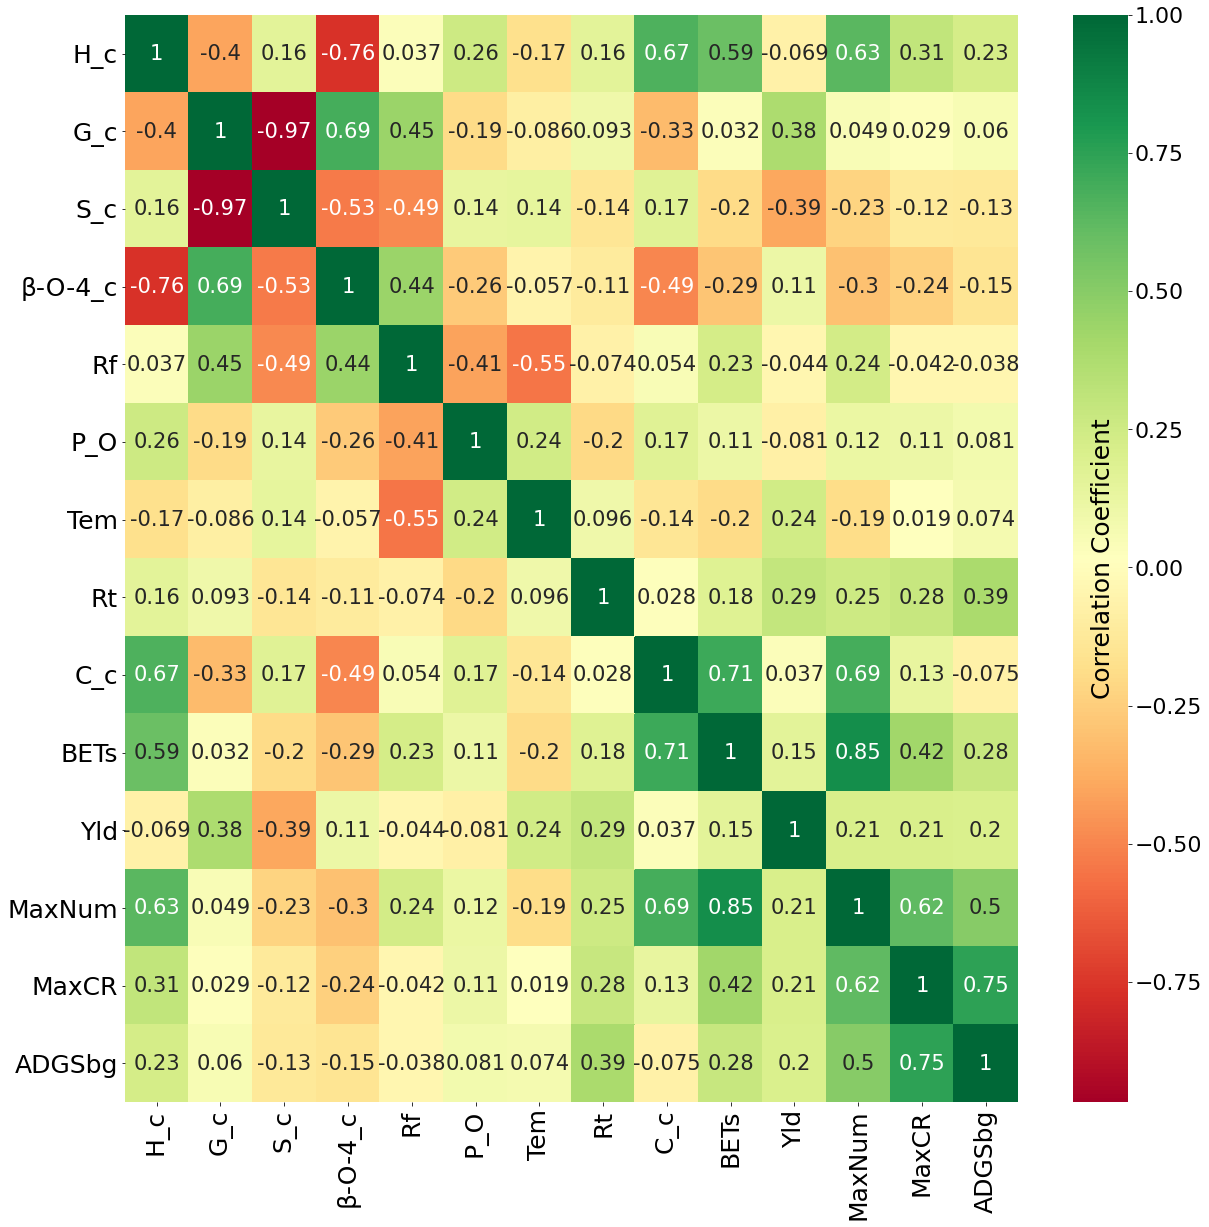

In [27]:
#【相关性热图】
plt.figure(figsize = (20,20))
heatmap = sns.heatmap(df_new_1.corr(), 
            cmap='RdYlGn', 
            annot=True, 
            annot_kws={"size": 21},  # 调整热力图中数字字体大小
            cbar_kws={'label': 'Correlation Coefficient'})  # 可选: 增加颜色条的标签

# 调整颜色条数字字体大小
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)  # 设置颜色条刻度字体大小

# 设置颜色条标签字体居中并设置字体颜色为白色
cbar.ax.set_ylabel('Correlation Coefficient', fontsize=25, color='black', labelpad=-30)  # 字体大小，颜色，间距
cbar.ax.yaxis.set_label_position('left')  # 确保标签在颜色条的右侧
cbar.ax.yaxis.label.set_verticalalignment('center')  # 标签垂直居中

# 调整坐标轴刻度的字体大小
plt.xticks(fontsize=25, rotation=90)  # x轴字体大小和旋转角度
plt.yticks(fontsize=25, rotation=0)   # y轴字体大小


plt.savefig('O2_催化_热力图.tiff', dpi = 770)

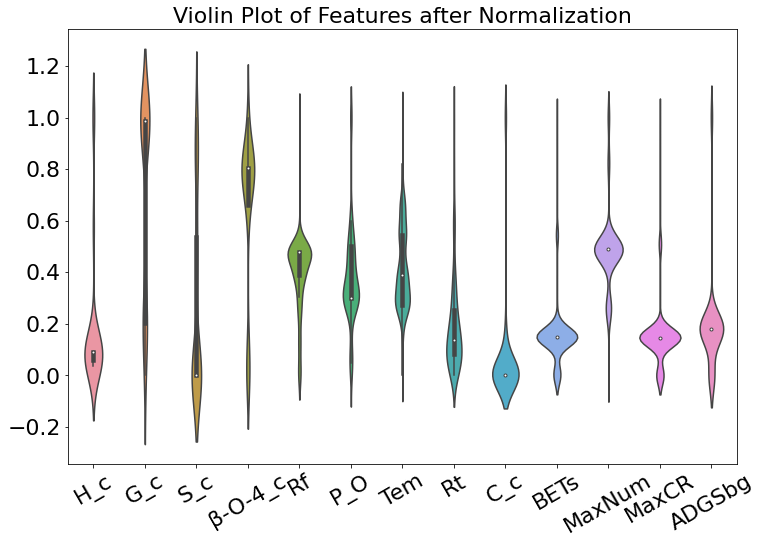

In [28]:
#【绘制小提琴图】
plt.figure(figsize=(12, 8))
sns.violinplot(data=X_scaled)

plt.xticks(rotation=30, fontsize=22)  # x轴刻度字体大小为12
plt.yticks(fontsize=22)  # y轴刻度字体大小为12

plt.title('Violin Plot of Features after Normalization', fontsize=22)  # 调整标题字体大小

plt.savefig('O2_C_violin_plot.png')  # 保存为 PNG 文件
plt.show()

training R2 = 0.996
test R2 = 0.725
RMSE(training)0.002
RMSE(test)0.015


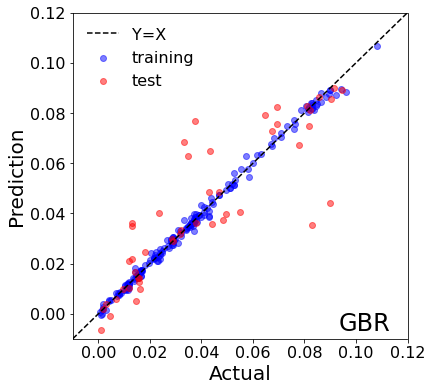

In [18]:
#【模型1】【梯度提升回归_网格化搜索】

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
#超参数网格化搜索方法
from sklearn.model_selection import GridSearchCV

# 定义模型
gbr = GradientBoostingRegressor()

# 定义要搜索的参数网格
param_grid = {
    'n_estimators': [100, 200, 300],  # 树的数量
    'learning_rate': [0.01, 0.1, 0.2],  # 学习率
    'max_depth': [3, 4, 5]  # 树的最大深度
}

# 定义评分方法
scorer = make_scorer(r2_score)  # 这里以R2分数为例，也可以使用RMSE

# 创建GridSearchCV对象
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, scoring=scorer, cv=12)

# 拟合数据
grid_search.fit(X_train, y_train)

# 使用最优参数预测
best_gbr = grid_search.best_estimator_

# 使用最优模型进行预测

y_pred_train_gbr = best_gbr.predict(X_train)
y_pred_test_gbr = best_gbr.predict(X_test)


#作图
import matplotlib.pyplot as plt

plt.figure(figsize = (6, 6))
plt.scatter(y_train, y_pred_train_gbr, alpha = 0.5, color = 'b', label = 'training')  #alpha设置透明度
plt.scatter(y_test, y_pred_test_gbr, alpha = 0.5, color = 'r', label = 'test')

# 添加 y=x 线
plt.plot([min(-0.01, 0.14), max(-0.01, 0.14)],  # X 轴范围
         [min(-0.01, 0.14), max(-0.01, 0.14)],  # Y 轴范围
         'k--', label='Y=X')  # 'k--' 是黑色虚线，您可以根据需要修改颜色和线型

# 设置图例字体大小
plt.legend(fontsize=16, frameon=False)
plt.xlabel('Actual', fontsize=20)
plt.ylabel('Prediction', fontsize=20)

# 设置轴刻度的字体大小
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# 设置X轴和Y轴的范围
plt.xlim([-0.01, 0.12])  # 替换min_value_x和max_value_x为您希望的范围的最小值和最大值
plt.ylim([-0.01, 0.12])  # 替换min_value_y和max_value_y为您希望的范围的最小值和最大值

# 在图的右上角添加文本
plt.text(0.95, 0.01, 'GBR', fontsize=24, ha='right', va='bottom', transform=plt.gca().transAxes)

plt.savefig('O2_C_梯度提升回归_网格搜索.tiff', dpi = 720, bbox_inches='tight')

#算均方误差
from sklearn.metrics import mean_squared_error #引用均方差

print('training R2 = %.3f' %best_gbr.score(X_train, y_train))
print('test R2 = %.3f' %best_gbr.score(X_test, y_test))
rmse_tr_gbr = mean_squared_error(y_train, y_pred_train_gbr, squared = False) #squared = False 是表示对均方差求根，及得到均方根误差
rmse_te_gbr = mean_squared_error(y_test, y_pred_test_gbr, squared = False)
print('RMSE(training)%.3f'%rmse_tr_gbr)
print('RMSE(test)%.3f'%rmse_te_gbr)

100%|█████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/trial, best loss: -0.7145324687099981]
Training R2 = 0.999
Test R2 = 0.797
RMSE (training): 0.001
RMSE (test): 0.013


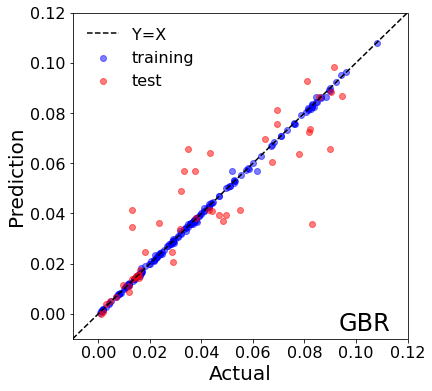

In [20]:
#【模型2】【梯度提升回归_贝叶斯优化搜索】

from hyperopt import hp, tpe, fmin, Trials
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np

# 定义目标函数
def objective(params):
    gbr = GradientBoostingRegressor(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        subsample=params['subsample'],
        max_features=params['max_features']
    )
    
    # 使用交叉验证评估模型性能
    score = cross_val_score(gbr, X_train, y_train, cv=10, scoring='r2').mean()
    
    # 目标是最大化 R² 分数，因此返回负值作为最小化目标
    return -score

# 定义超参数搜索空间
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None])
}

# 创建一个用于存储调参过程的 Trials 对象
trials = Trials()

# 使用贝叶斯优化算法（TPE）进行参数搜索
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,  # 指定最大评估次数
    trials=trials,
    rstate=np.random.default_rng(42)  # 设置随机种子
)

# 使用最优参数重新训练GBR模型
best_gbr = GradientBoostingRegressor(
    n_estimators=int(best_params['n_estimators']),
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    subsample=best_params['subsample'],
    max_features=['auto', 'sqrt', 'log2', None][best_params['max_features']]  # 使用找到的最优值
)

# 拟合训练数据
best_gbr.fit(X_train, y_train)

# 进行预测
y_pred_train_gbr = best_gbr.predict(X_train)
y_pred_test_gbr = best_gbr.predict(X_test)

# 作图
plt.figure(figsize = (6, 6))
plt.scatter(y_train, y_pred_train_gbr, alpha = 0.5, color = 'b', label = 'training')  # alpha设置透明度
plt.scatter(y_test, y_pred_test_gbr, alpha = 0.5, color = 'r', label = 'test')

# 添加 y=x 线
plt.plot([min(-0.01, 0.14), max(-0.01, 0.14)],  # X 轴范围
         [min(-0.01, 0.14), max(-0.01, 0.14)],  # Y 轴范围
         'k--', label='Y=X')  # 'k--' 是黑色虚线

# 设置图例字体大小
plt.legend(fontsize=16, frameon=False)
plt.xlabel('Actual', fontsize=20)
plt.ylabel('Prediction', fontsize=20)

# 设置轴刻度的字体大小
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# 设置X轴和Y轴的范围
plt.xlim([-0.01, 0.12])  # 替换min_value_x和max_value_x为您希望的范围的最小值和最大值
plt.ylim([-0.01, 0.12])  # 替换min_value_y和max_value_y为您希望的范围的最小值和最大值

# 在图的右上角添加文本
plt.text(0.95, 0.01, 'GBR', fontsize=24, ha='right', va='bottom', transform=plt.gca().transAxes)

plt.savefig('O2_C_梯度提升回归_贝叶斯优化搜索tiff', dpi = 720, bbox_inches='tight')

# 输出模型性能
print('Training R2 = %.3f' % best_gbr.score(X_train, y_train))
print('Test R2 = %.3f' % best_gbr.score(X_test, y_test))

# 计算均方根误差（RMSE）
rmse_train_gbr = mean_squared_error(y_train, y_pred_train_gbr, squared=False)
rmse_test_gbr = mean_squared_error(y_test, y_pred_test_gbr, squared=False)
print('RMSE (training): %.3f' % rmse_train_gbr)
print('RMSE (test): %.3f' % rmse_test_gbr)

training R2 = 0.864
test R2 = 0.617
RMSE(training): 0.009
RMSE(test): 0.018


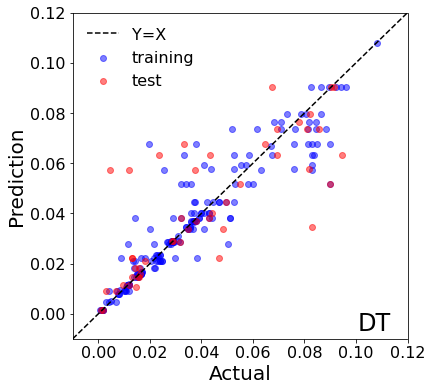

In [30]:
#【模型3】【决策树回归_网格化搜索】

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 定义模型
dtr = DecisionTreeRegressor()

# 定义要搜索的参数网格
param_grid_dt = {
    'max_depth': [3, 4, 5, 10, 15],  # 树的最大深度
    'min_samples_split': [2, 5, 10],  # 节点分裂所需的最小样本数
    'min_samples_leaf': [1, 2, 5]  # 叶节点的最小样本数
}

# 定义评分方法
scorer_dt = make_scorer(r2_score)  # 使用R2分数

# 创建GridSearchCV对象
grid_search_dt = GridSearchCV(estimator=dtr, param_grid=param_grid_dt, scoring=scorer_dt, cv=10)

# 拟合数据
grid_search_dt.fit(X_train, y_train)

# 使用最优参数预测
best_dtr = grid_search_dt.best_estimator_

# 使用最优模型进行预测
y_pred_train_dt = best_dtr.predict(X_train)
y_pred_test_dt = best_dtr.predict(X_test)

# 作图
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred_train_dt, alpha=0.5, color='b', label='training')  # alpha设置透明度
plt.scatter(y_test, y_pred_test_dt, alpha=0.5, color='r', label='test')

# 添加 y=x 线
plt.plot([min(-0.01, 0.14), max(-0.01, 0.14)],  # X 轴范围
         [min(-0.01, 0.14), max(-0.01, 0.14)],  # Y 轴范围
         'k--', label='Y=X')  # 'k--' 是黑色虚线

# 设置图例字体大小
plt.legend(fontsize=16, frameon=False)
plt.xlabel('Actual', fontsize=20)
plt.ylabel('Prediction', fontsize=20)

# 设置轴刻度的字体大小
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# 设置X轴和Y轴的范围
plt.xlim([-0.01, 0.12])  # 替换min_value_x和max_value_x为您希望的范围的最小值和最大值
plt.ylim([-0.01, 0.12])  # 替换min_value_y和max_value_y为您希望的范围的最小值和最大值

# 在图的右上角添加文本
plt.text(0.95, 0.01, 'DT', fontsize=24, ha='right', va='bottom', transform=plt.gca().transAxes)

plt.savefig('O2_C_决策树回归_网格化搜索_不交叉验证.tiff', dpi=720, bbox_inches='tight')

# 计算R2和均方误差
print('training R2 = %.3f' % best_dtr.score(X_train, y_train))
print('test R2 = %.3f' % best_dtr.score(X_test, y_test))
rmse_tr_dt = mean_squared_error(y_train, y_pred_train_dt, squared=False)  # 均方根误差
rmse_te_dt = mean_squared_error(y_test, y_pred_test_dt, squared=False)
print('RMSE(training): %.3f' % rmse_tr_dt)
print('RMSE(test): %.3f' % rmse_te_dt)

100%|█████████████████████████████████████████████| 100/100 [00:03<00:00, 27.22trial/s, best loss: -0.6065132621295856]
Best parameters found by Hyperopt: {'max_depth': 17.0, 'max_features': 0, 'min_samples_leaf': 1.0, 'min_samples_split': 10.0}
training R2 = 0.864
test R2 = 0.617
RMSE(training): 0.009
RMSE(test): 0.018


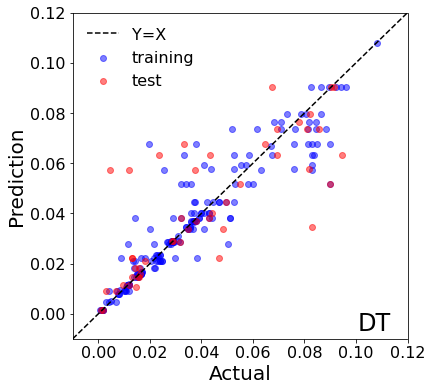

In [29]:
#【模型4】【决策树回归_贝叶斯优化搜索】

from hyperopt import hp, tpe, fmin, Trials
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import numpy as np

# 定义目标函数
def objective(params):
    # 创建决策树回归器，并使用传入的超参数
    dtr = DecisionTreeRegressor(
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        max_features=params['max_features']
    )
    
    # 使用交叉验证评估模型性能，这里使用 10 折交叉验证
    score = cross_val_score(dtr, X_train, y_train, cv=10, scoring='r2').mean()
    
    # 目标是最大化 R² 分数，因此返回负的 R² 作为最小化目标
    return -score

# 定义超参数搜索空间
space = {
    'max_depth': hp.quniform('max_depth', 3, 20, 1),  # 树的最大深度，离散均匀分布
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),  # 节点分裂所需的最小样本数
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),  # 叶节点最小样本数
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None])  # 最大特征数选择
}

# 创建一个用于存储调参过程的 Trials 对象
trials = Trials()

# 使用贝叶斯优化算法（TPE）进行参数搜索
best_params = fmin(
    fn=objective,  # 目标函数
    space=space,  # 超参数搜索空间
    algo=tpe.suggest,  # 贝叶斯优化算法
    max_evals=100,  # 最大评估次数
    trials=trials,  # 记录调参过程
    rstate=np.random.default_rng(42)  # 设置随机种子
)

# 输出最佳超参数
print("Best parameters found by Hyperopt:", best_params)

# 使用最优参数重新训练决策树模型
best_dtr = DecisionTreeRegressor(
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    max_features=['auto', 'sqrt', 'log2', None][best_params['max_features']]  # 使用找到的最优值
)

# 拟合训练数据
best_dtr.fit(X_train, y_train)

# 进行预测
y_pred_train_dt = best_dtr.predict(X_train)
y_pred_test_dt = best_dtr.predict(X_test)

# 作图
plt.figure(figsize = (6, 6))
plt.scatter(y_train, y_pred_train_dt, alpha = 0.5, color = 'b', label = 'training')  # alpha设置透明度
plt.scatter(y_test, y_pred_test_dt, alpha = 0.5, color = 'r', label = 'test')

# 添加 y=x 线
plt.plot([min(-0.01, 0.14), max(-0.01, 0.14)],  # X 轴范围
         [min(-0.01, 0.14), max(-0.01, 0.14)],  # Y 轴范围
         'k--', label='Y=X')  # 'k--' 是黑色虚线

# 设置图例字体大小
plt.legend(fontsize=16, frameon=False)
plt.xlabel('Actual', fontsize=20)
plt.ylabel('Prediction', fontsize=20)

# 设置轴刻度的字体大小
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# 设置X轴和Y轴的范围
plt.xlim([-0.01, 0.12])  # 替换min_value_x和max_value_x为您希望的范围的最小值和最大值
plt.ylim([-0.01, 0.12])  # 替换min_value_y和max_value_y为您希望的范围的最小值和最大值

plt.text(0.95, 0.01, 'DT', fontsize=24, ha='right', va='bottom', transform=plt.gca().transAxes) # 在图的右上角添加文本
plt.savefig('O2_C_决策树回归_贝叶斯优化_回归不交叉验证.tiff', dpi = 720, bbox_inches='tight')

# 输出模型性能
print('training R2 = %.3f' % best_dtr.score(X_train, y_train))
print('test R2 = %.3f' % best_dtr.score(X_test, y_test))
rmse_tr_dt = mean_squared_error(y_train, y_pred_train_dt, squared=False) # 计算均方根误差（RMSE）
rmse_te_dt = mean_squared_error(y_test, y_pred_test_dt, squared=False) # 计算均方根误差（RMSE）
print('RMSE(training): %.3f' % rmse_tr_dt)
print('RMSE(test): %.3f' % rmse_te_dt)
